In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

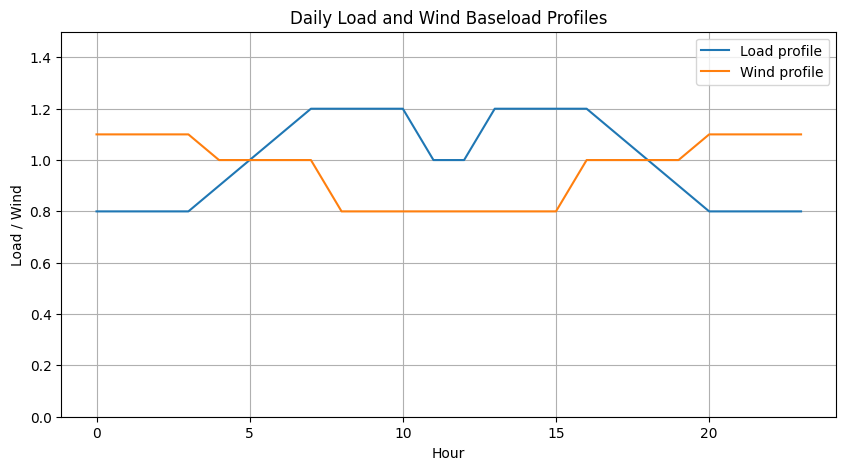

In [3]:
# Function to generate samples for loads and wind production, using baseload daily profiles and adding variability
daily_wind_baseload_profile = [1.1, 1.1, 1.1, 1.1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1, 1, 1, 1, 1.1, 1.1, 1.1, 1.1]
daily_load_baseload_profile = [0.8, 0.8, 0.8, 0.8, 0.9, 1, 1.1, 1.2, 1.2, 1.2, 1.2, 1, 1, 1.2, 1.2, 1.2, 1.2, 1.1, 1, 0.9, 0.8, 0.8, 0.8, 0.8]

# Plot the daily profiles, with y axis going from 0 to 1.5
plt.figure(figsize=(10, 5))
plt.plot(daily_load_baseload_profile, label="Load profile")
plt.plot(daily_wind_baseload_profile, label="Wind profile")
plt.ylabel("Load / Wind")
plt.ylim(0, 1.5)
plt.xlabel("Hour")
plt.legend()
plt.title("Daily Load and Wind Baseload Profiles")
plt.grid(True)
plt.show()


In [ ]:
# Function to generate samples
def generate_samples(daily_load_baseload_profile, daily_wind_baseload_profile, num_samples, sd_noise, sd_mean, loads_mean, wind_mean):
    data = []
    for sample_num in range(1, num_samples + 1):
        mean_variability = np.random.normal(0, sd_mean)
        for hour in range(24):
            noise_variability = np.random.normal(0, sd_noise)
            # Generate samples for loads
            load_sample = [
                mean * (1 + mean_variability) * daily_load_baseload_profile[hour] * (1 + noise_variability)
                for mean in loads_mean
            ]
            # Generate samples for wind
            wind_sample = [
                mean * (1 + mean_variability) * daily_wind_baseload_profile[hour] * (1 + noise_variability)
                for mean in wind_mean
            ]
            # Combine into a row
            row = [sample_num, hour] + load_sample + wind_sample
            data.append(row)
    return data

In [5]:
# Parameters
loads_mean = [56, 112, 112]  # Mean values for L1, L2, L3
wind_mean = [10, 30]  # Maximum capacity for W1 and W2

# Generate samples
num_samples = 10
sd_mean = 0.1
sd_noise = 0.05
samples_data = generate_samples(
    daily_load_baseload_profile, daily_wind_baseload_profile, num_samples, sd_noise, sd_mean, loads_mean, wind_mean
)

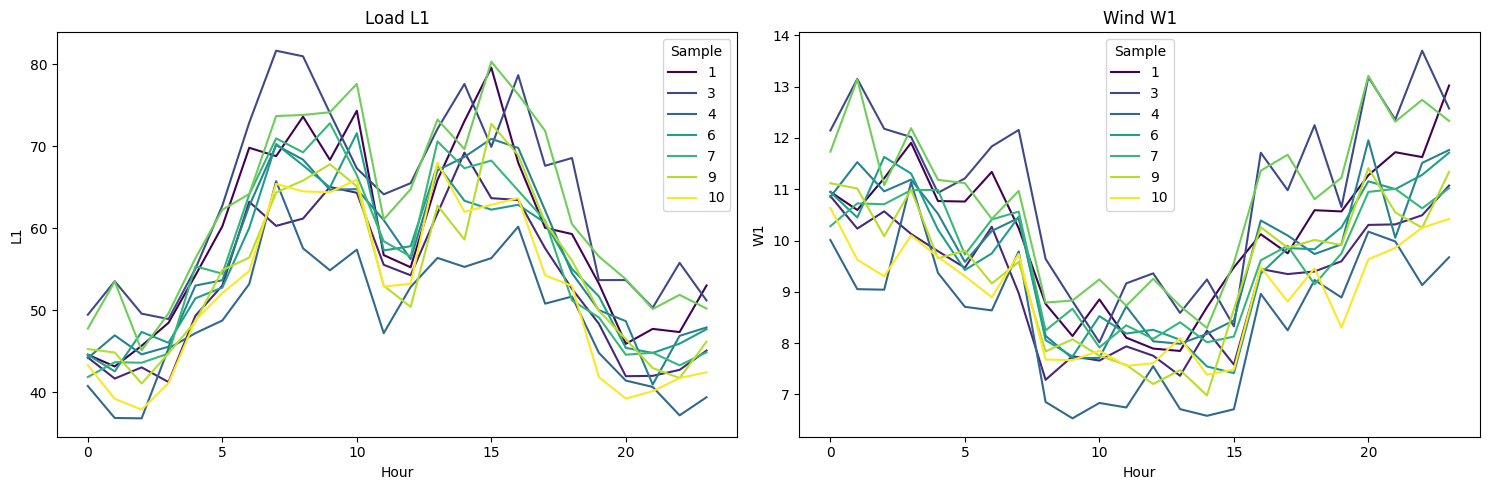

In [6]:
# Create a DataFrame
columns = ["Sample", "Hour", "L1", "L2", "L3", "W1", "W2"]
samples_df = pd.DataFrame(samples_data, columns=columns)

# Plot the samples for load L1 and W1 in two subplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x="Hour", y="L1", data=samples_df, hue="Sample", palette="viridis")
plt.title("Load L1")
plt.subplot(1, 2, 2)
sns.lineplot(x="Hour", y="W1", data=samples_df, hue="Sample", palette="viridis")
plt.title("Wind W1")
plt.tight_layout()
plt.show()



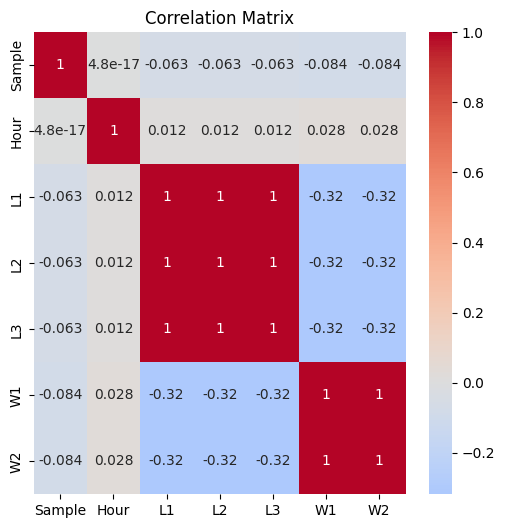

In [ ]:
# Correlation matrix
correlation_matrix = samples_df.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

## Task 1] Build the optimisation model

In [63]:
# Load the data from the data folder
wind_forecast = samples_df[['Hour', 'W1', 'W2']].copy()
load = samples_df[['Hour', 'L1', 'L2','L3']].copy()
#wind_forecast = pd.read_csv('../Data/1.Wind forecast profile.csv', delimiter=';')
#load = pd.read_csv('../Data/1.Load profile.csv', delimiter=';')
bus = pd.read_csv('../Data/B (power transfer factor of each bus to each line).csv', delimiter=';')
max_prod = pd.read_csv('../Data/Maximum production of generating units.csv', delimiter=';')
min_prod = pd.read_csv('../Data/Minimum production of generating units.csv', delimiter=';')
min_down_time = pd.read_csv('../Data/Minimum down time of generating units.csv', delimiter=';')
min_up_time = pd.read_csv('../Data/Minimum up time of generating units.csv', delimiter=';')
prod_cost = pd.read_csv('../Data/Production cost of generating units.csv', delimiter=';')
ramp_rate = pd.read_csv('../Data/Ramping rate of generating units.csv', delimiter=';')
start_up_cost = pd.read_csv('../Data/Start-up cost of generating units.csv', delimiter=';')
transmission_cap = pd.read_csv('../Data/Transmission capacity of lines.csv', delimiter=';')


In [46]:
Nodes = ['Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', 'Node 6']
Generator = ['G1', 'G2', 'G3']
Generator_node = {'Node 1': 'G1', 'Node 2': 'G2', 'Node 6': 'G3'}
Load = ['L1', 'L2', 'L3']
Load_node = {'Node 4': 'L1', 'Node 5': 'L2', 'Node 6': 'L3'}
Wind = ['W1', 'W2']
Wind_node = {'Node 4': 'W1', 'Node 5': 'W2'}
Transmission = ['Line 1', 'Line 2', 'Line 3', 'Line 4', 'Line 5', 'Line 6','Line 7']
Transmission_node = {'Line 1': ['Node 1', 'Node 2'], 'Line 2': ['Node 2', 'Node 3'], 'Line 3': ['Node 3', 'Node 6'], 'Line 4': ['Node 5', 'Node 6'], 'Line 5': ['Node 4', 'Node 5'], 'Line 6': ['Node 2', 'Node 4'],'Line 6': ['Node 1', 'Node 4']}    

In [47]:
# Create matrix with the nodes as columns and the generators, loads and winds as rows, with 1 if connected to the node
Gen_n = np.zeros((len(Generator), len(Nodes)))
Load_n = np.zeros((len(Load), len(Nodes)))
Wind_n = np.zeros((len(Wind), len(Nodes)))
Transmission_n = np.zeros((len(Transmission), len(Nodes)))

# Populate the matrix
for i, g in enumerate(Generator):  # Iterate over generators
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Generator_node.get(node) == g:  # Check if generator is connected to the node
            Gen_n[i, j] = 1

for i, l in enumerate(Load):  # Iterate over loads
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Load_node.get(node) == l:  # Check if load is connected to the node
            Load_n[i, j] = 1

for i, w in enumerate(Wind):  # Iterate over winds
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Wind_node.get(node) == w:  # Check if wind is connected to the node
            Wind_n[i, j] = 1

for i, t in enumerate(Transmission):  # Iterate over transmission lines
    connected_nodes = Transmission_node.get(t, [])  # Get nodes connected by the transmission line
    for node in connected_nodes:  # For each node connected by the transmission line
        if node in Nodes:  # Ensure the node is valid (exists in Nodes list)
            j = Nodes.index(node)  # Get the column index for the node in Transmission_n
            Transmission_n[i, j] = 1  # Set the corresponding element to 1
            


In [48]:
# Define the input data class
class InputData:
    
    def __init__(
        self,
        wind_forecast: pd.DataFrame, 
        bus: pd.DataFrame,
        load: pd.DataFrame,
        max_prod: pd.DataFrame,
        min_prod: pd.DataFrame,
        min_down_time: pd.DataFrame,
        min_up_time: pd.DataFrame,
        prod_cost: pd.DataFrame,
        ramp_rate: pd.DataFrame,
        start_up_cost: pd.DataFrame,
        transmission_cap: pd.DataFrame
    ):
        self.time = range(len(wind_forecast))  #maybe define it with lenght of wind_production
        self.wind_forecast = wind_forecast
        self.bus = bus
        self.load = load
        self.max_prod = max_prod
        self.min_prod = min_prod
        self.min_down_time = min_down_time
        self.min_up_time = min_up_time
        self.prod_cost = prod_cost
        self.ramp_rate = ramp_rate
        self.start_up_cost = start_up_cost
        self.transmission_cap = transmission_cap
        self.M = 1000000  # Penalty for having flexible demand
        self.Gen_n = Gen_n  # Matrix mapping generators to nodes
        self.Load_n = Load_n # Matrix mapping loads to nodes
        self.Wind_n = Wind_n # Matrix mapping wind to nodes
        
        


In [49]:
class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [50]:
# Define the optimization model class

class EconomicDispatch():
        
        def __init__(self, input_data: InputData):
            self.data = input_data 
            self.variables = Expando()
            self.constraints = Expando() 
            self.results = Expando() 
            self._build_model() 
            
        def _build_variables(self):
            # one binary variable for the status of each generator
            self.variables.status = {
                (i, t): self.model.addVar(vtype=GRB.BINARY, 
                                            name='status_G{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.max_prod)+1) 
                                            for t in self.data.time}
            
            # one variable for each generator for each time of the day
            self.variables.prod_gen = {
                 (i, t): self.model.addVar(lb=0, ub=self.data.max_prod.iloc[i-1, 0], 
                                           name='generation_G{}_{}'.format(i, t)) 
                                           for i in range(1, len(self.data.max_prod)+1) 
                                           for t in self.data.time}
            
            # one variable for each wind generator for each time of the day
            self.variables.prod_wind = {
                 (i, t): self.model.addVar(lb=0, ub=self.data.wind_forecast.iloc[t, i], 
                                            name='wind_generation_W{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.wind_forecast.iloc[0, :])) 
                                            for t in self.data.time}
            
            # one variable for each start-up cost for each generator
            self.variables.start_up_cost = {
                 (i, t): self.model.addVar(lb=0, 
                                            name='start_up_cost_G{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.max_prod)+1) 
                                            for t in self.data.time}
            
            # add two slack variables to always make the model feasible, allowing the demand to be flexible
            self.variables.epsilon = {
                 (n, t): self.model.addVar(lb=0, 
                                           name='epsilon_Bus{}_{}'.format(n, t)) 
                                           for n in range(1, len(self.data.bus.iloc[0,:])+1) 
                                           for t in self.data.time}
            self.variables.delta = {
                 (n, t): self.model.addVar(lb=0, 
                                           name='delta_Bus{}_{}'.format(n, t))
                                           for n in range(1, len(self.data.bus.iloc[0,:])+1)
                                           for t in self.data.time}
            
            
        def _build_constraints(self):
            # Minimum capacity of the generator
            self.constraints.min_capacity = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] >= self.data.min_prod.iloc[i-1, 0] * self.variables.status[i, t]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time}
            # Maximum capacity of the generator
            self.constraints.max_capacity = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] <= self.data.max_prod.iloc[i-1, 0] * self.variables.status[i, t]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time}

            # Power balance constraint
            self.constraints.power_balance = {
                t: self.model.addConstr(
                    gp.quicksum(self.variables.prod_gen[i, t] for i in range(1, len(self.data.max_prod) + 1)) +
                    gp.quicksum(self.variables.prod_wind[i, t] for i in range(1, len(self.data.wind_forecast.iloc[0, :]))) == 
                    gp.quicksum(self.data.load.iloc[t, i] * Load_n[i-1, n-1] for i in range(1, len(self.data.load.iloc[0, :]))for n in range(1, len(self.data.bus.iloc[0, :]) + 1))
                    + gp.quicksum(self.variables.epsilon[n, t] - self.variables.delta[n, t] for n in range(1, len(self.data.bus.iloc[0, :]) + 1))
                ) for t in self.data.time}
        
            

            # Transmission capacity constraint up
            self.constraints.transmission_capacity_up = {
                    (l, t): self.model.addConstr(
                        gp.quicksum(
                            self.data.bus.iloc[l-1, n-1] * Transmission_n[l-1, n-1] * (
                                self.variables.prod_gen[g, t] * Gen_n[g-1, n-1] +
                                self.variables.prod_wind[w, t] * Wind_n[w-1, n-1] -
                                self.data.load.iloc[t, i] * Load_n[i-1, n-1] -
                                self.variables.epsilon[n, t] +
                                self.variables.delta[n, t]
                            )
                            for n in range(1, len(self.data.bus.iloc[0, :]) + 1)
                            for i in range(1, len(self.data.load.iloc[0, :]))
                            for g in range(1, len(self.data.max_prod) + 1)
                            for w in range(1, len(self.data.wind_forecast.iloc[0, :]))
                        ) <= self.data.transmission_cap.iloc[l-1, 0],
                        name="transmission_capacity_up_L{}_T{}".format(l, t)
                    ) for l in range(1, len(self.data.transmission_cap) + 1)
                    for t in self.data.time
                }


            #Transmission capacity constraint down
            self.constraints.transmission_capacity_down = {
                    (l, t): self.model.addConstr(
                        gp.quicksum(
                            self.data.bus.iloc[l-1, n-1] * Transmission_n[l-1, n-1] * (
                                self.variables.prod_gen[g, t] * Gen_n[g-1, n-1] +
                                self.variables.prod_wind[w, t] * Wind_n[w-1, n-1] -
                                self.data.load.iloc[t, i] * Load_n[i-1, n-1] -
                                self.variables.epsilon[n, t] +
                                self.variables.delta[n, t]
                            )
                            for n in range(1, len(self.data.bus.iloc[0, :]) + 1)
                            for i in range(1, len(self.data.load.iloc[0, :]))
                            for g in range(1, len(self.data.max_prod) + 1)
                            for w in range(1, len(self.data.wind_forecast.iloc[0, :]))
                        ) >= -self.data.transmission_cap.iloc[l-1, 0],
                        name="transmission_capacity_down_L{}_T{}".format(l, t)
                    ) for l in range(1, len(self.data.transmission_cap) + 1)
                    for t in self.data.time
                }

                                     

            #Start-up costs constraint
            self.constraints.start_up_cost = {
                (i, t): self.model.addConstr(
                    self.variables.start_up_cost[i, t] >= self.data.start_up_cost.iloc[i-1, 0] * (self.variables.status[i, t] - self.variables.status[i, t-1])
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            self.constraints.start_up_cost_0 = {
                i: self.model.addConstr(
                    self.variables.start_up_cost[i, 0] >= self.data.start_up_cost.iloc[i-1, 0] * self.variables.status[i, 0]
                ) for i in range(1, len(self.data.max_prod)+1)}
            
            # Ramping constraint
            self.constraints.ramping_up = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] - self.variables.prod_gen[i, t-1] <= self.data.ramp_rate.iloc[i-1, 0]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            self.constraints.ramping_down = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t-1] - self.variables.prod_gen[i, t] <= self.data.ramp_rate.iloc[i-1, 0]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            
            # Minimum up time constraint
            self.constraints.min_up_time = {
                (i, t, to): self.model.addConstr(
                    -self.variables.status[i, t - 1] + self.variables.status[i, t] - self.variables.status[i, to] <= 0
                ) for i in range(1, len(self.data.max_prod)+1) 
                for t in self.data.time 
                for to in range(t, min(t + self.data.min_up_time.iloc[i-1, 0], len(self.data.time))) if t > 0}
            
            # Minimum down time constraint
            self.constraints.min_down_time = {
                (i, t, to): self.model.addConstr(
                    self.variables.status[i, t - 1] - self.variables.status[i, t] + self.variables.status[i, to] <= 1
                ) for i in range(1, len(self.data.max_prod)+1) 
                for t in self.data.time 
                for to in range(t, min(t + self.data.min_down_time.iloc[i-1, 0], len(self.data.time))) if t > 0}
            


        def _build_objective(self):
            # Objective function
            self.model.setObjective(
                gp.quicksum(self.data.prod_cost.iloc[i-1, 0]*self.variables.prod_gen[i, t] for i in range(1, len(self.data.max_prod)+1) for t in self.data.time) +
                gp.quicksum(self.variables.start_up_cost[i, t] for i in range(1, len(self.data.max_prod)+1) for t in self.data.time) +
                self.data.M * (gp.quicksum(self.variables.epsilon[n, t] + self.variables.delta[n, t] for n in range(1, len(self.data.bus.iloc[0,:])+1) for t in self.data.time))
            )

        def _build_model(self):
            self.model = gp.Model('EconomicDispatch')
            self._build_variables()
            self._build_constraints()
            self._build_objective()
            self.model.update()

        def optimize(self):
            self.model.optimize()
            self._extract_results()

        def _extract_results(self):
            self.results.production = pd.DataFrame({
                #'time': [t for t in self.data.time],
                #'status G1': [self.variables.status[1, t].x for t in self.data.time],
                #'status G2': [self.variables.status[2, t].x for t in self.data.time],
                #'status G3': [self.variables.status[3, t].x for t in self.data.time],
                #'start_up_cost 1': [self.variables.start_up_cost[1, t].x for t in self.data.time],
                #'start_up_cost 2': [self.variables.start_up_cost[2, t].x for t in self.data.time],
                #'start_up_cost 3': [self.variables.start_up_cost[3, t].x for t in self.data.time],
                'generation 1': [self.variables.prod_gen[1, t].x for t in self.data.time],
                'generation 2': [self.variables.prod_gen[2, t].x for t in self.data.time],
                'generation 3': [self.variables.prod_gen[3, t].x for t in self.data.time],
                'wind generation 1': [self.variables.prod_wind[1, t].x for t in self.data.time],
                'wind generation 2': [self.variables.prod_wind[2, t].x for t in self.data.time],
                'load 1': [self.data.load.iloc[t, 1] for t in self.data.time],
                'load 2': [self.data.load.iloc[t, 2] for t in self.data.time],
                'load 3': [self.data.load.iloc[t, 3] for t in self.data.time],
                'epsilon 1': [self.variables.epsilon[1, t].x for t in self.data.time],
                'delta 1': [self.variables.delta[1, t].x for t in self.data.time],
                'epsilon 2': [self.variables.epsilon[2, t].x for t in self.data.time],
                'delta 2': [self.variables.delta[2, t].x for t in self.data.time],
                'epsilon 3': [self.variables.epsilon[3, t].x for t in self.data.time],
                'delta 3': [self.variables.delta[3, t].x for t in self.data.time],
                'epsilon 4': [self.variables.epsilon[4, t].x for t in self.data.time],
                'delta 4': [self.variables.delta[4, t].x for t in self.data.time],
                'epsilon 5': [self.variables.epsilon[5, t].x for t in self.data.time],
                'delta 5': [self.variables.delta[5, t].x for t in self.data.time],
                'epsilon 6': [self.variables.epsilon[6, t].x for t in self.data.time],
                'delta 6': [self.variables.delta[6, t].x for t in self.data.time]
            })
            self.results.unit_commitment = pd.DataFrame({
                'time': [t for t in self.data.time],
                'G1': [self.variables.status[1, t].x for t in self.data.time],
                'G2': [self.variables.status[2, t].x for t in self.data.time],
                'G3': [self.variables.status[3, t].x for t in self.data.time]
            })
            
        def _print_model(self):
            self.model.write('EconomicDispatch.lp')        
            
                 

In [89]:
# Parameters
loads_mean = [56, 112, 112]  # Mean values for L1, L2, L3
wind_mean = [10, 30]  # Maximum capacity for W1 and W2

# Generate samples
num_samples = 10
sd_mean = 0.5
sd_noise = 0.05
samples_data = generate_samples(
    daily_load_baseload_profile, daily_wind_baseload_profile, num_samples, sd_noise, sd_mean, loads_mean, wind_mean
)

In [90]:
# Create a DataFrame
columns = ["Sample", "Hour", "L1", "L2", "L3", "W1", "W2"]
samples_df = pd.DataFrame(samples_data, columns=columns)

# Load the data from the data folder
wind_forecast = samples_df[['Hour', 'W1', 'W2']].copy()
load = samples_df[['Hour', 'L1', 'L2','L3']].copy()

In [91]:
# devide the values of load by 2
load.iloc[:, 1:] = load.iloc[:, 1:] / 2

# Run the model
input_data = InputData(wind_forecast.head(72), bus, load.head(72), max_prod, min_prod, min_down_time, min_up_time, prod_cost, ramp_rate, start_up_cost, transmission_cap)
model = EconomicDispatch(input_data)
model.optimize()
results = model.results.production
# model._build_model()
# model._print_model()


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3203 rows, 1656 columns and 9912 nonzeros
Model fingerprint: 0x138f8e42
Variable types: 1440 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [4e-01, 9e+02]
  Objective range  [1e+00, 1e+06]
  Bounds range     [1e+00, 2e+02]
  RHS range        [3e-01, 5e+02]
Found heuristic solution: objective 1.488651e+10
Presolve removed 1058 rows and 145 columns
Presolve time: 0.09s
Presolved: 2145 rows, 1511 columns, 8451 nonzeros
Variable types: 1224 continuous, 287 integer (287 binary)

Root relaxation: objective 1.561976e+07, 535 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0    

In [92]:
# Create a dataframe with the results of G1, G2, G3
occurences = model.results.unit_commitment[['G1', 'G2', 'G3']].sum()/len(model.results.unit_commitment)
occurences

G1    1.000000
G2    0.194444
G3    0.694444
dtype: float64

In [93]:
model.results.unit_commitment #to be used for the next steps

,time,G1,G2,G3
0,0,1.0,0.0,0.0
1,1,1.0,0.0,0.0
2,2,1.0,0.0,0.0
3,3,1.0,0.0,0.0
4,4,1.0,0.0,0.0
...,...,...,...,...
67,67,1.0,0.0,1.0
68,68,1.0,0.0,0.0
69,69,1.0,0.0,0.0
70,70,1.0,0.0,0.0
